## Deep-dive into RAG

Retrieval-augmented generation (RAG) combines two cutting-edge technologies: information retrieval (IR) and natural language generation (NLG), or text generation.

To appreciate the innovation RAG offers, it’s essential to understand the complex interaction between these two elements.

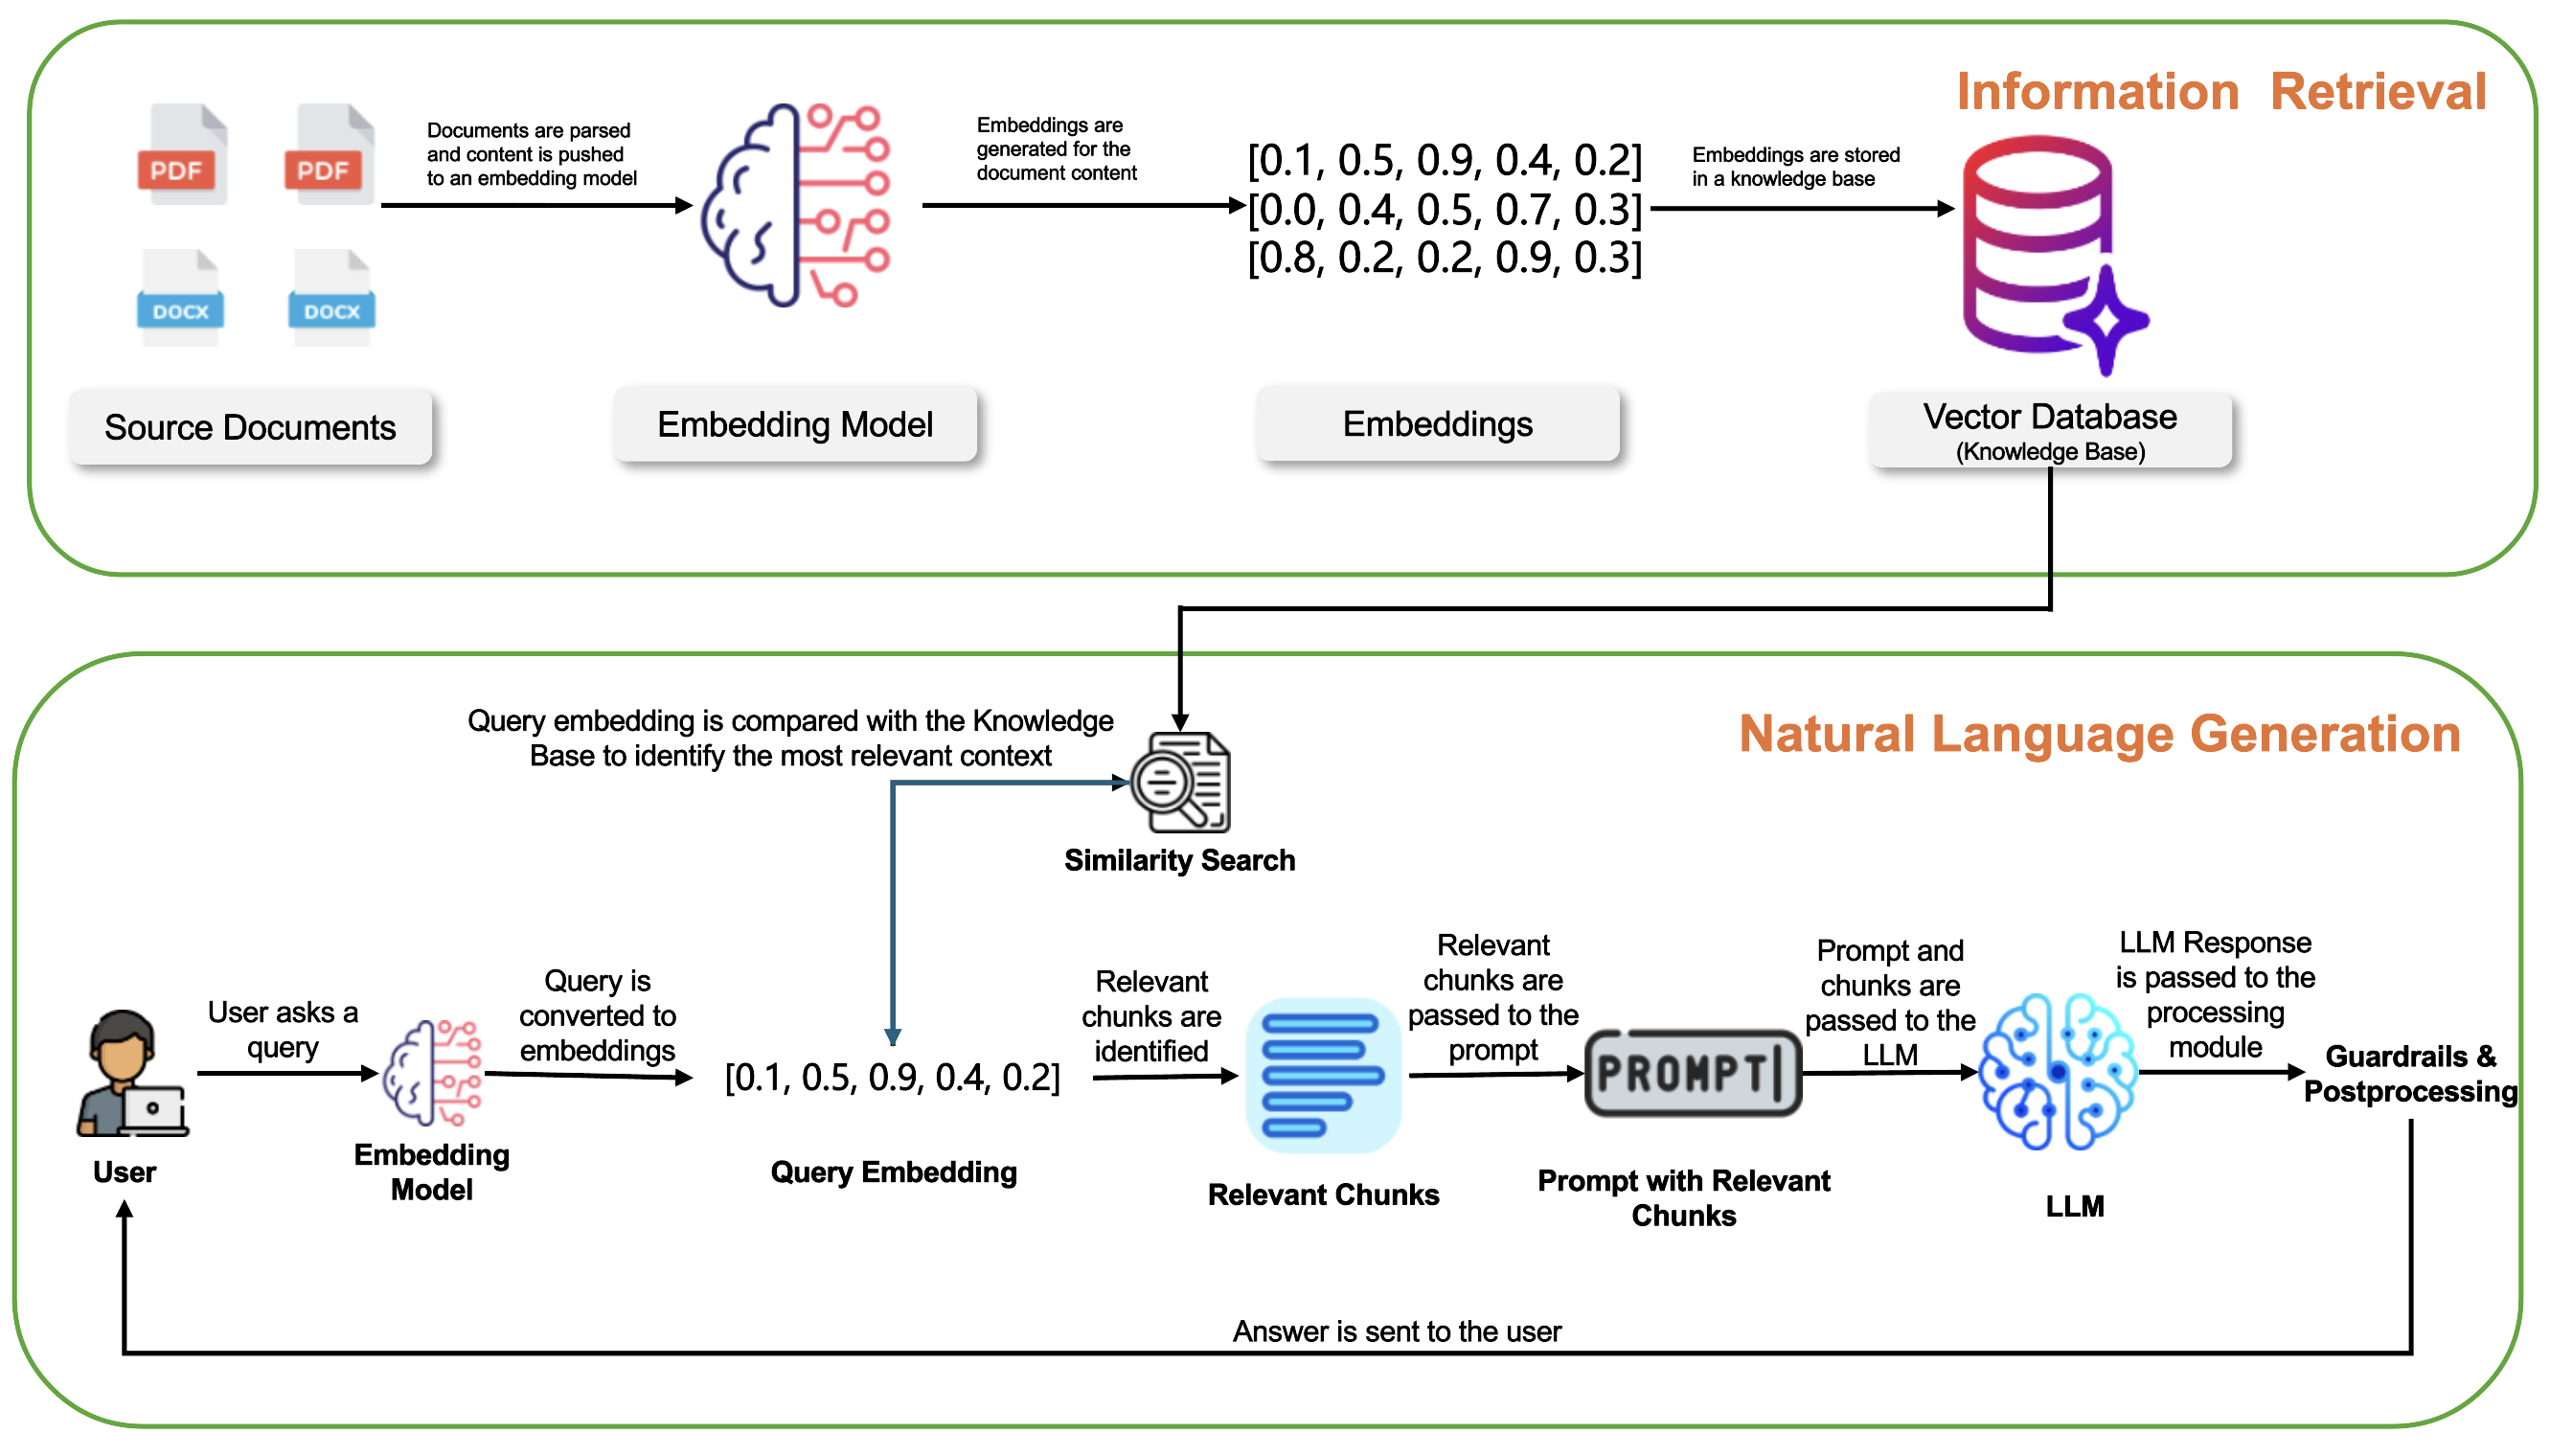

In [2]:
## Setting up the LLM

In [2]:
!pip install --upgrade langchain
!pip install --upgrade langchain-core
!pip install --upgrade langchain-community
!pip install --upgrade langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.8 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:


In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
help(ChatGoogleGenerativeAI)

Help on class ChatGoogleGenerativeAI in module langchain_google_genai.chat_models:

class ChatGoogleGenerativeAI(langchain_google_genai._common._BaseGoogleGenerativeAI, langchain_core.language_models.chat_models.BaseChatModel)
 |  ChatGoogleGenerativeAI(*, name: Optional[str] = None, cache: Union[langchain_core.caches.BaseCache, bool, NoneType] = None, verbose: bool = <factory>, callbacks: Union[list[langchain_core.callbacks.base.BaseCallbackHandler], langchain_core.callbacks.base.BaseCallbackManager, NoneType] = None, tags: Optional[list[str]] = None, metadata: Optional[dict[str, Any]] = None, custom_get_token_ids: Optional[Callable[[str], list[int]]] = None, callback_manager: Optional[langchain_core.callbacks.base.BaseCallbackManager] = None, rate_limiter: Optional[langchain_core.rate_limiters.BaseRateLimiter] = None, disable_streaming: Union[bool, Literal['tool_calling']] = False, model: str, api_key: Optional[pydantic.types.SecretStr] = <factory>, credentials: Any = None, temperatu

In [4]:
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage

# 1. Initialize the Chat Model (from the previous step)
chat_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash",
                                  temperature=0,
                                  google_api_key=userdata.get('GOOGLE_API_KEY'))

# 2. Prepare the messages
# The SystemMessage sets the behavior and context for the AI.
# The HumanMessage is the user's actual query.
messages = [
    SystemMessage(content="You're an assistant knowledgeable about healthcare. Only answer healthcare-related questions."),
    HumanMessage(content="What is Ayushman Bharat?"),
]

# 3. Invoke the model with the messages
result = chat_model.invoke(messages) # notice the similarity with model.predict from sklearn

print(result.content)

Ayushman Bharat is a flagship national health protection scheme launched by the Government of India in 2018. Its primary goal is to achieve Universal Health Coverage (UHC) and ensure that no one is left behind due to financial constraints when seeking healthcare.

The scheme has two main components:

1.  **Pradhan Mantri Jan Arogya Yojana (PMJAY):** This is the health insurance component, often referred to as the world's largest government-funded health insurance scheme.
    *   **Objective:** To provide financial protection to over 50 crore (500 million) poor and vulnerable families for secondary and tertiary care hospitalization.
    *   **Coverage:** It offers a health cover of up to ₹5 lakh (approximately $6,000 USD) per family per year for cashless and paperless treatment at empanelled public and private hospitals across India.
    *   **Benefits:** Covers pre-hospitalization expenses, hospitalization expenses, and post-hospitalization expenses for a wide range of medical and surg

#### Second Test

In [5]:
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage

# 1. Initialize the Chat Model
chat_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash",
                                  temperature=0,
                                  google_api_key=userdata.get('GOOGLE_API_KEY'))

# 2. Prepare messages with an out-of-scope question
messages = [
    SystemMessage(content="You're an assistant knowledgeable about healthcare. Only answer healthcare-related questions."),
    HumanMessage(content="How do I change a tire?"),
]

# 3. Invoke the model
result = chat_model.invoke(messages)

print(result.content)

I can only answer healthcare-related questions. Changing a tire is not a healthcare topic.


# Using ChatPromptTemplates

In [6]:
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 1. Initialize the Chat Model
chat_model = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
                                  temperature=0,
                                  google_api_key=userdata.get('GOOGLE_API_KEY'))

# 2. Create the Prompt Template
instruction_str = """Your job is to use patient reviews to answer questions about their experience at a hospital.
Use the following context to answer questions. Be as detailed as possible, but don't make up any information that's not from the context.
If you don't know an answer, say you don't know.

Context: {context}

Question: {question}
"""

review_template = ChatPromptTemplate.from_template(instruction_str)

# 3. Define the context and question
context = "The discharge process was seamless!"
question = "Did anyone have a positive experience?"

# 4. Create the chain by piping the components together
#    We also add an output parser to get a clean string result.
chain = review_template | chat_model | StrOutputParser()

# 5. Invoke the chain with the input variables
result = chain.invoke({
    "context": context,
    "question": question
})

print(result)

Yes, at least one person had a positive experience, noting that the discharge process was seamless.


## Using PromptTemplates & MessageTemplates

In [7]:
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import (
    PromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    ChatPromptTemplate
)
from langchain_core.output_parsers import StrOutputParser

# 1. Initialize the Chat Model
chat_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash",
                                  temperature=0,
                                  google_api_key=userdata.get('GOOGLE_API_KEY'))

# 2. Create the detailed prompt templates
instruction_str = """Your job is to use patient reviews to answer questions about their experience at a hospital.
Use the following context to answer questions.
Be as detailed as possible, but don't make up any information that's not from the context.
If you don't know an answer, say you don't know.

Context: {context}
"""

review_system_prompt = SystemMessagePromptTemplate(
    prompt=PromptTemplate(
        input_variables=["context"], template=instruction_str
    )
)

review_human_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(
        input_variables=["question"], template="{question}"
    )
)

messages = [review_system_prompt, review_human_prompt]

# This is our final, reusable prompt template
review_prompt_template = ChatPromptTemplate(
    input_variables=["context", "question"],
    messages=messages,
)

# 3. Define the context and question
context = "I had a great stay!"
question = "Did anyone have a positive experience?"

# 4. Create the chain
chain = review_prompt_template | chat_model | StrOutputParser()

# 5. Invoke the chain
result = chain.invoke({
    "context": context,
    "question": question
})

print(result)

Yes, one patient stated, "I had a great stay!"


In [8]:
context = "I had a negative stay!"
question = "Did anyone have a positive experience?"

chain.invoke({"context": context, "question": question})

'Based on the provided context, it only states, "I had a negative stay!" There is no information about anyone having a positive experience.'

# Adding RAG

In [9]:
!pip install -U langchain-chroma # FAISS

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 124.7 MB/s et

In [13]:
import time
from google.colab import userdata

# Import the CSVLoader class to load documents from a CSV file.
from langchain.document_loaders.csv_loader import CSVLoader

# Import the Chroma class, which is used to create and interact with a Chroma vector database.
from langchain_chroma import Chroma

# Import the GoogleGenerativeAIEmbeddings class to create numerical vector representations (embeddings) of text using Google's models.
from langchain_google_genai import GoogleGenerativeAIEmbeddings


REVIEWS_CSV_PATH = "/content/reviews.csv"

# Define a constant variable for the directory where the Chroma vector database will be stored.
REVIEWS_CHROMA_PATH = "chroma_data"


# Create an instance of the CSVLoader.
loader = CSVLoader(
    file_path=REVIEWS_CSV_PATH,  # Specify the path to the CSV file to be loaded.
    source_column="review"       # Specify the name of the column that contains the main text content.
)

# Call the .load() method on the loader instance.
# This reads the specified column from the CSV file and loads the content into a list of Document objects.
reviews = loader.load()

# Specify the embedding function to use. We define it once to be reused.
embedding_function = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001",  # Choose the specific embedding model provided by Google.
    google_api_key=userdata.get('GOOGLE_API_KEY')  # Securely fetch the Google API key.
)

# Set the size of each batch to process.
batch_size = 20
# Calculate the total number of batches.
num_batches = (len(reviews) - 1) // batch_size + 1
reviews_vector_db = None

# Loop through the documents in batches to avoid hitting the API's rate limit.
for i in range(0, len(reviews), batch_size):
    # Get the current batch of documents.
    batch_docs = reviews[i:i + batch_size]
    current_batch_num = i // batch_size + 1

    print(f"Processing batch {current_batch_num}/{num_batches}...")

    if i == 0:
        # For the first batch, create a new Chroma vector database.
        # The `from_documents` method handles the entire process of embedding and storing the data.
        reviews_vector_db = Chroma.from_documents(
            documents=batch_docs,  # Pass the list of Document objects that need to be embedded.
            embedding=embedding_function,
            # Specify the directory on the disk where the vector database will be saved.
            # This makes the database persistent, so we can load it directly in the future.
            persist_directory=REVIEWS_CHROMA_PATH
        )
    else:
        # For subsequent batches, add the documents to the existing database.
        reviews_vector_db.add_documents(documents=batch_docs)

    # Pause the script for 30 seconds after each batch to respect the per-minute rate limit.
    print(f"Batch {current_batch_num} processed. Waiting for 30 seconds...")
    time.sleep(30)

print("Vector database created successfully and saved to the specified directory.")

Processing batch 1/51...
Batch 1 processed. Waiting for 30 seconds...
Processing batch 2/51...
Batch 2 processed. Waiting for 30 seconds...
Processing batch 3/51...
Batch 3 processed. Waiting for 30 seconds...
Processing batch 4/51...
Batch 4 processed. Waiting for 30 seconds...
Processing batch 5/51...
Batch 5 processed. Waiting for 30 seconds...
Processing batch 6/51...
Batch 6 processed. Waiting for 30 seconds...
Processing batch 7/51...
Batch 7 processed. Waiting for 30 seconds...
Processing batch 8/51...
Batch 8 processed. Waiting for 30 seconds...
Processing batch 9/51...
Batch 9 processed. Waiting for 30 seconds...
Processing batch 10/51...
Batch 10 processed. Waiting for 30 seconds...
Processing batch 11/51...
Batch 11 processed. Waiting for 30 seconds...
Processing batch 12/51...
Batch 12 processed. Waiting for 30 seconds...
Processing batch 13/51...
Batch 13 processed. Waiting for 30 seconds...


KeyboardInterrupt: 

## Retrieval

In [14]:
question = """Has anyone complained about communication with the hospital staff?"""
relevant_chunks = reviews_vector_db.similarity_search(question, k=3)

relevant_chunks[0].page_content

'review_id: 1001\nvisit_id: 3240\nreview: I was disappointed with the lack of communication between different departments in the hospital. It led to confusion about my treatment plan and discharge instructions.\nphysician_name: Ronald Hernandez Jr.\nhospital_name: Wallace-Hamilton\npatient_name: Jacob Smith'

In [15]:
from langchain.schema.runnable import RunnablePassthrough  # Allows passing inputs through unchanged in a pipeline
from langchain_core.output_parsers import StrOutputParser  # Parses the model's output into a clean string

# Create a retriever to fetch the top 10 most relevant reviews based on a query
reviews_retriever = reviews_vector_db.as_retriever(k=10)
# The `as_retriever` method converts the database into a retriever.
# `k=10` specifies that the retriever should return the top 10 most relevant documents for a query.

# Create a chain for querying and generating responses
review_chain = (
    {"context": reviews_retriever, "question": RunnablePassthrough()}
    # Step 1: Retrieves relevant reviews (`context`) and passes the `question` unchanged
    | review_prompt_template
    # Step 2: Formats the retrieved reviews and the user's question into a structured prompt
    | chat_model
    # Step 3: Sends the prompt to the Gemini chat model to generate a response
    | StrOutputParser()
    # Step 4: Parses the model's raw output into a clean string format for easier use
)

In [16]:
question = """Has anyone complained about communication with the hospital staff?"""
review_chain.invoke(question)

'Yes, several patients have complained about communication with the hospital staff:\n\n*   **Jacob Smith** (review_id: 1001, visit_id: 3240 at Wallace-Hamilton hospital) was disappointed with the lack of communication between different departments, which led to confusion about his treatment plan and discharge instructions.\n*   **Daniel Harris** (review_id: 954, visit_id: 1077 at Bell, Mcknight and Willis hospital) stated that the communication among the staff was poor, leading to confusion about his treatment plan.\n*   **Loretta Schmitt** (review_id: 1, visit_id: 761 at Bell, Mcknight and Willis hospital) noted that communication between the staff and patients was lacking, and felt that improvement was needed in patient care. She also mentioned that the nurses seemed overwhelmed.'

# Putting it all together

In [23]:
from langchain.prompts import (
    PromptTemplate,  # Template for formatting prompts with dynamic variables
    SystemMessagePromptTemplate,  # Represents a system-level instruction to the model
    HumanMessagePromptTemplate,  # Represents a human-level input for the model
    ChatPromptTemplate,  # Combines multiple prompt components into a unified chat prompt
)

# Define the system prompt template as a string with placeholders for dynamic content
review_template_str = """Your job is to use patient reviews to answer questions about their experience at a hospital.
Use the following context to answer questions.
Be as detailed as possible, but don't make up any information that's not from the context.
If you don't know an answer, say you don't know.

{context}
"""

# Create a system-level message prompt template for the chatbot
review_system_prompt = SystemMessagePromptTemplate(
    prompt=PromptTemplate(
        input_variables=["context"],  # Placeholder for the "context" (e.g., patient reviews)
        template=review_template_str,  # The instructions and structure of the system prompt
    )
)

# Create a human-level message prompt template for user input
review_human_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(
        input_variables=["question"],  # Placeholder for the "question" to be answered
        template="{question}",  # A simple template where the "question" is dynamically inserted
    )
)

# Combine the system and human prompts into a list of messages
messages = [review_system_prompt, review_human_prompt]

# Create a chat prompt template that integrates the system and human prompts
review_prompt_template = ChatPromptTemplate(
    input_variables=["context", "question"],  # Define the expected inputs for the template
    messages=messages,  # Combine the individual prompt components (system and human)
)

In [26]:
from langchain_google_genai import ChatGoogleGenerativeAI
chat_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite",
                                  temperature=0,
                                  google_api_key=userdata.get('GOOGLE_API_KEY_SIVA'))

In [27]:
# Importing required modules and classes
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import (
    PromptTemplate,  # Template for structuring prompts
    SystemMessagePromptTemplate,  # System-level instructions for the model
    HumanMessagePromptTemplate,  # Human input instructions for the model
    ChatPromptTemplate,  # Combines system and human prompts into a single chat prompt
)
from langchain_core.output_parsers import StrOutputParser  # Parses the model's output into a clean string
from langchain_community.vectorstores import Chroma  # Vector database for efficient similarity searches
from langchain_google_genai import GoogleGenerativeAIEmbeddings  # Converts text to embeddings using Google's API
from langchain.schema.runnable import RunnablePassthrough  # Allows passing inputs through unchanged in a pipeline

# Path to the persistent Chroma vector database
REVIEWS_CHROMA_PATH = "chroma_data"

# Specify the embedding function to use. We define it once to be reused.
embedding_function = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",  # Choose the specific embedding model provided by Google.
    google_api_key=userdata.get('GOOGLE_API_KEY_SIVA')  # Securely fetch the Google API key.
)

# Set the size of each batch to process.
batch_size = 20
# Calculate the total number of batches.
num_batches = (len(reviews) - 1) // batch_size + 1
reviews_vector_db = None

# Loop through the documents in batches to avoid hitting the API's rate limit.
for i in range(0, len(reviews), batch_size):
    # Get the current batch of documents.
    batch_docs = reviews[i:i + batch_size]
    current_batch_num = i // batch_size + 1

    print(f"Processing batch {current_batch_num}/{num_batches}...")

    if i == 0:
        # For the first batch, create a new Chroma vector database.
        # The `from_documents` method handles the entire process of embedding and storing the data.
        reviews_vector_db = Chroma.from_documents(
            documents=batch_docs,  # Pass the list of Document objects that need to be embedded.
            embedding=embedding_function,
            # Specify the directory on the disk where the vector database will be saved.
            # This makes the database persistent, so we can load it directly in the future.
            persist_directory=REVIEWS_CHROMA_PATH
        )
    else:
        # For subsequent batches, add the documents to the existing database.
        reviews_vector_db.add_documents(documents=batch_docs)

    # Pause the script for 60 seconds after each batch to respect the per-minute rate limit.
    print(f"Batch {current_batch_num} processed. Waiting for 30 seconds...")
    time.sleep(30)

print("Vector database created successfully and saved to the specified directory.")

Processing batch 1/51...


GoogleGenerativeAIError: Error embedding content: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/embed_content_free_tier_requests, limit: 0
* Quota exceeded for metric: generativelanguage.googleapis.com/embed_content_free_tier_requests, limit: 0
* Quota exceeded for metric: generativelanguage.googleapis.com/embed_content_free_tier_requests, limit: 0
* Quota exceeded for metric: generativelanguage.googleapis.com/embed_content_free_tier_requests, limit: 0 [violations {
  quota_metric: "generativelanguage.googleapis.com/embed_content_free_tier_requests"
  quota_id: "EmbedContentRequestsPerDayPerProjectPerModel-FreeTier"
}
violations {
  quota_metric: "generativelanguage.googleapis.com/embed_content_free_tier_requests"
  quota_id: "EmbedContentRequestsPerDayPerUserPerProjectPerModel-FreeTier"
}
violations {
  quota_metric: "generativelanguage.googleapis.com/embed_content_free_tier_requests"
  quota_id: "EmbedContentRequestsPerMinutePerUserPerProjectPerModel-FreeTier"
}
violations {
  quota_metric: "generativelanguage.googleapis.com/embed_content_free_tier_requests"
  quota_id: "EmbedContentRequestsPerMinutePerProjectPerModel-FreeTier"
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
]

In [28]:
# Create a retriever to fetch the top 10 most relevant reviews based on a query
reviews_retriever = reviews_vector_db.as_retriever(k=10)
# The `as_retriever` method converts the database into a retriever.
# `k=10` specifies that the retriever should return the top 10 most relevant documents for a query.

# Create a chain for querying and generating responses
review_chain = (
    {"context": reviews_retriever, "question": RunnablePassthrough()}
    # Step 1: Retrieves relevant reviews (`context`) and passes the `question` unchanged
    | review_prompt_template
    # Step 2: Formats the retrieved reviews and the user's question into a structured prompt
    | chat_model
    # Step 3: Sends the prompt to the OpenAI chat model to generate a response
    | StrOutputParser()
    # Step 4: Parses the model's raw output into a clean string format for easier use
)

AttributeError: 'NoneType' object has no attribute 'as_retriever'

In [21]:
question = """Has anyone complained about communication with the hospital staff?"""
review_chain.invoke(question)

'Yes, several patients have complained about communication with the hospital staff:\n\n*   **Jacob Smith** (review_id: 1001) was disappointed with the "lack of communication between different departments in the hospital," which led to confusion about his treatment plan and discharge instructions.\n*   **Daniel Harris** (review_id: 954) stated that "communication among the staff was poor," causing confusion about his treatment plan.\n*   **Loretta Schmitt** (review_id: 1) noted that "communication between the staff and patients was lacking" and that the nurses seemed overwhelmed.'

# Gradio as ChatInterface

In [29]:
!pip install gradio

In [30]:
def respond_to_user_question(question: str, history: list) -> str:
    """
    Respond to a user's question using the review_chain.
    """
    return review_chain.invoke(question)

In [31]:
respond_to_user_question("Has anyone complained about communication with the hospital staff?", [])

'Yes, several patients have complained about communication with the hospital staff:\n\n*   **Jacob Smith (review_id: 1001)** was disappointed with the "lack of communication between different departments in the hospital," which led to confusion about his treatment plan and discharge instructions.\n*   **Daniel Harris (review_id: 954)** stated that "communication among the staff was poor," resulting in confusion about his treatment plan.\n*   **Loretta Schmitt (review_id: 1)** noted that "communication between the staff and patients was lacking" and that the nurses seemed overwhelmed.'

In [32]:
import gradio as gr
# Create the Gradio ChatInterface
interface = gr.ChatInterface(fn=respond_to_user_question, title="Review Helper Bot")

# Launch the Gradio app
interface.launch(debug=True)

/usr/local/lib/python3.12/dist-packages/gradio/chat_interface.py:348: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3149c4113a631cbeb8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3149c4113a631cbeb8.gradio.live


# Questions were asked in Chat Interface

* Do we have cafeterias in hospitals, how was the food quality?
* Do we have private rooms in hospitals , how was the maintanence quality
* Do we have enough parking space do we need to pay fee?
* Nurses and supporting staffs were supportive to patients?
* Do we get the discharge plan prior?

And the answers were satisfying.

In [34]:
question = """Do we have cafeterias in hospitals, how was the food quality?"""
review_chain.invoke(question)

'Yes, the reviews indicate that hospitals have cafeterias.\n\nRegarding the food quality, it was generally described as subpar and bland. Patients noted that the cafeteria food options were limited, the menu was repetitive, and there was a lack of variety, which affected the overall patient experience.'

In [35]:
question = """Do we have private rooms in hospitals , how was the maintanence quality"""
review_chain.invoke(question)

'Based on the reviews:\n\nRegarding private rooms, some patients experienced a "lack of privacy in the shared hospital rooms," noting "constant noise and lack of personal space" which made it challenging to rest and recover peacefully. Another patient also mentioned "the lack of privacy in the shared rooms was a drawback." However, one patient found "the hospital\'s commitment to patient privacy was reassuring," though they also noted an outdated television in their room.\n\nRegarding maintenance quality, one patient stated that "The hospital facilities were modern and well-equipped." Another patient mentioned that "the outdated television in the room was a minor inconvenience during my stay."'

In [36]:
question = """Do we have enough parking space do we need to pay fee?"""
review_chain.invoke(question)

'Based on the patient reviews, there is a **lack of parking spaces** which is described as a major inconvenience for both patients and visitors, adding unnecessary stress to visits and making it difficult for family to visit.\n\nThe provided context does not contain any information about whether a parking fee needs to be paid.'

In [37]:
question = """Nurses and supporting staffs were supportive to patients?"""
review_chain.invoke(question)

'Yes, based on the patient reviews:\n\n*   The nursing staff was described as **friendly and supportive**.\n*   The support from the nursing staff was **exceptional**, making stays more pleasant.\n*   The nursing staff was **caring**, making hospital stays more bearable.\n*   The nursing staff was also **attentive and caring**, with the hospital showing a commitment to patient well-being.'

In [38]:
question = """Do we get the discharge plan prior?"""
review_chain.invoke(question)

'Based on the patient reviews, there were issues with the communication of discharge plans and instructions:\n\n*   One patient experienced a "lack of clear communication about post-discharge care instructions."\n*   Another patient noted a "lack of communication between different departments" which led to "confusion about my treatment plan and discharge instructions."\n*   A patient also expressed disappointment with the "lack of follow-up care after my discharge," feeling unsupported in their recovery journey.\n\nThe context does not explicitly state whether a discharge plan is provided prior to discharge, but it highlights problems with the clarity and communication of these instructions.'

# Downloading the chroma-data folders



In [33]:
import shutil
import os
import zipfile

folders_to_zip = [
    "/content/chroma_data",
]

output_zip_file = "/content/chroma_data.zip"

try:
    with zipfile.ZipFile(output_zip_file, 'w', zipfile.ZIP_DEFLATED, allowZip64=True) as zipf:
        for folder_path in folders_to_zip:
            for root, _, files in os.walk(folder_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, "/content") # Create archive name relative to /content
                    zipf.write(file_path, arcname)
    print(f"Folders zipped successfully to {output_zip_file}")

except Exception as e:
    print(f"Error during zipping process: {e}")

Folders zipped successfully to /content/chroma_data.zip
